tgb - 2/22/2019 - The goal is to reproduce the R2 scores plots from the original GRL paper about NNCAM
Here, I am mostly following https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/presentation/grl_paper.ipynb and the networks are defined and trained in https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/005_Predicting_convective_and_radiative_heating_profiles.ipynb

# 1) Load the neural networks

## 1.1) Import modules

In [1]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.models import *
from cbrain.losses import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp32fbp_andkua/'
PREFIX = '32_col_rad_12m_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/home/t/Tom.Beucler/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 1.2) Directly load conserving and unconstrained networks

In [2]:
%cd $TRAINDIR/HDF5_DATA
!pwd
C_rad_5dens = load_model('C_rad_5dens.h5')
U_rad_5dens = load_model('U_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


## 1.3) Define the weakly-constrained models then load weights
tgb - 2/22/2019 - The custom loss function did not save properly so I am redefining the custom loss function, the model and then loading the weights of the trained networks.

### 1.3.1) Define custom loss function

In [3]:
def customLoss(input_tensor,fsub,fdiv,normq,hyai,hybi,alpha = 0.5):

        # tgb - 2/5/2019 - Loss function written above
    def lossFunction(y_true,y_pred):    
        loss = tfm.multiply(alpha, mse(y_true, y_pred))
        loss += tfm.multiply(tfm.subtract(1.0,alpha), \
                            massent_res(input_tensor,y_pred,fsub,fdiv,normq,hyai,hybi))
        return loss

    # tgb - 2/5/2019 - Mass and enthalpy residual function
    # Adapted from massent_check by converting numpy to tensorflow
    def massent_res(x,y,fsub,fdiv,normq,hyai,hybi):

        # 0) Constants
        G = 9.80616; # Reference gravity constant [m.s-2]
        L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
        L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
        L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
        P0 = 1e5; # Reference surface pressure [Pa]   

        # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
        # In the input vector, PS is the 151st element after 
        # the first elements = [QBP, ..., VBP with shape 30*5=150]
        PS = tfm.add( tfm.multiply( x[:,300], fdiv[300]), fsub[300])
        # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
        P = tfm.add( tfm.multiply( P0, hyai), \
        tfm.multiply( PS[:,None], hybi))
        dP = tfm.subtract( P[:, 1:], P[:, :-1])
        # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
        dP_NORM = tfm.divide( \
        tfm.multiply(normq[:30], \
                  G),\
        L_V)
        # dp_tilde = dp/dp_norm
        dP_TILD = tfm.divide( dP, dP_NORM)

        # WATER.1) Calculate water vertical integral from level 1 to level 30
        WATVEC = tfm.multiply( dP_TILD, tfm.add(tfm.add(y[:, :30],\
                                                        y[:, 30:60]),\
                                                y[:, 60:90]))
        WATINT = tfm.reduce_sum( WATVEC, axis=1)

        # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
        # E-P is already normalized to units W.m-2 in the output vector
        # so all we need to do is input-unnormalize LHF that is taken from the input vector
        LHF = tfm.add( tfm.multiply( x[:,303], fdiv[303]), fsub[303])
        # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
        # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
        PREC = tfm.add( y[:, 214], y[:, 215])

        # WATER.FINAL) Residual = E-P-DWATER/DT
        WATRES = tfm.add(tfm.add(LHF,\
                                 tfm.negative(PREC)),\
                         tfm.negative(WATINT))

        # ENTHALPY.1) Calculate net energy input from phase change and precipitation
        # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
        PHAS = tfm.divide( tfm.multiply( tfm.subtract(\
                                              tfm.add( y[:,216], y[:,217]),\
                                              tfm.add( y[:,214], y[:,215])),\
                                      L_F),\
                         L_V)

        # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
        # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
        RAD = tfm.add(\
                      tfm.subtract( y[:,210], y[:,211]),\
                      tfm.subtract( y[:,213], y[:,212]))
        # 2.2) Unnormalize sensible heat flux
        SHF = tfm.add( tfm.multiply( x[:,302], fdiv[302]), fsub[302])
        # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
        # turbulent kinetic energy energy dissipative heating
        KEDVEC = tfm.multiply( dP_TILD, y[:, 120:150])
        KEDINT = tfm.reduce_sum( KEDVEC, axis=1)

        # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
        # 3.1) Column water vapor is the column integral of specific humidity
        PHQVEC = tfm.multiply( dP_TILD, y[:, :30])
        PHQINT = tfm.reduce_sum( PHQVEC, axis=1)
        # 3.2) Multiply by L_S/L_V to normalize (explanation above)
        SPDQINT = tfm.divide( tfm.multiply( tfm.subtract(\
                                                     PHQINT, LHF),\
                                        L_S),\
                           L_V)

        # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
        SPDQCINT = tfm.divide( tfm.multiply(\
                                      tfm.reduce_sum(\
                                             tfm.multiply( dP_TILD, y[:, 30:60]),\
                                             axis=1),\
                                      L_F),\
                         L_V)

        # ENTHALPY.5) Same operation for temperature tendency
        DTINT = tfm.reduce_sum( tfm.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)

        # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
        ENTRES = tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(tfm.add(SPDQINT,\
                                                                 SPDQCINT),\
                                                         DTINT),\
                                                 tfm.negative(RAD)),\
                                         tfm.negative(SHF)),\
                                 tfm.negative(PHAS)),\
                         tfm.negative(KEDINT))
        # Return sum of water and enthalpy square residuals
        return tfm.add( tfm.square(WATRES), tfm.square(ENTRES))

    return lossFunction

### 1.3.2) Define weakly-constrained model

In [4]:
# Weakly-constrained models with 5 dense layers
# alpha=0.01
inp001 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp001)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W001_rad_5dens = Model(inputs=inp001, outputs=out)
# alpha=0.5
inp05 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp05)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W05_rad_5dens = Model(inputs=inp05, outputs=out)
# alpha=0.99
inp099 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp099)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W099_rad_5dens = Model(inputs=inp099, outputs=out)

### 1.3.3) Load normalization files and compile weakly-constrained model with custom loss function

In [5]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


In [6]:
W001_rad_5dens.compile(loss=customLoss(inp001,fsub,fdiv,normq,hyai,hybi,alpha = 0.01),\
                       optimizer='rmsprop')
W05_rad_5dens.compile(loss=customLoss(inp05,fsub,fdiv,normq,hyai,hybi,alpha = 0.5),\
                       optimizer='rmsprop')
W099_rad_5dens.compile(loss=customLoss(inp099,fsub,fdiv,normq,hyai,hybi,alpha = 0.99),\
                       optimizer='rmsprop')

### 1.3.4) Load neural network weights

In [282]:
%cd $TRAINDIR/HDF5_DATA
!pwd
W001_rad_5dens.load_weights('W001_rad_5dens.h5')
W05_rad_5dens.load_weights('W05_rad_5dens.h5')
W099_rad_5dens.load_weights('W099_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


# 2) Geographical figures

## 2.1) Define coordinates, variables and units

In [36]:
coor = xr.open_dataset(DATADIR + "AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
print(coor.time)

<xarray.DataArray 'time' (time: 48)>
array([0.      , 0.020833, 0.041667, 0.0625  , 0.083333, 0.104167, 0.125   ,
       0.145833, 0.166667, 0.1875  , 0.208333, 0.229167, 0.25    , 0.270833,
       0.291667, 0.3125  , 0.333333, 0.354167, 0.375   , 0.395833, 0.416667,
       0.4375  , 0.458333, 0.479167, 0.5     , 0.520833, 0.541667, 0.5625  ,
       0.583333, 0.604167, 0.625   , 0.645833, 0.666667, 0.6875  , 0.708333,
       0.729167, 0.75    , 0.770833, 0.791667, 0.8125  , 0.833333, 0.854167,
       0.875   , 0.895833, 0.916667, 0.9375  , 0.958333, 0.979167])
Coordinates:
  * time     (time) float64 0.0 0.02083 0.04167 0.0625 ... 0.9375 0.9583 0.9792
Attributes:
    long_name:  time
    units:      days since 0000-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bnds


tgb - 3/18/2019 - Test stack function below for section 2.2

In [10]:
# Stephan stacks the data in the following order: time,lat,lon
VAR = ds.T.stack(sample=('time', 'lat', 'lon'))
print('VAR.shape(lev,sample) =',VAR.shape,'derived from T.shape(time,lev,lat,lon) =',ds.T.shape)

VAR.shape(lev,sample) = (30, 393216) derived from T.shape(time,lev,lat,lon) = (48, 30, 64, 128)


In [11]:
# Let's compare the original T array with the stacked array VAR
ilev = 15; # Reference vertical level for testing
# The first element of both arrays is equal
VAR[ilev,0]-ds.T[0,ilev,0,0]
# The second element is itime=0, ilat=0, ilon=1
VAR[ilev,1]-ds.T[0,ilev,0,1]
# The third element is itime=0, ilat=0, ilon=2
print(VAR[ilev,2]-ds.T[0,ilev,0,2])
# The 129th element is itime=0, ilat=1, ilon=0
VAR[ilev,ds.T.shape[3]]-ds.T[0,ilev,1,0]
# The (128*64)th element is itime=1, ilat=0, ilon=0
VAR[ilev,ds.T.shape[2]*ds.T.shape[3]]-ds.T[1,ilev,0,0]

<xarray.DataArray 'T' ()>
array(0., dtype=float32)
Coordinates:
    lev      float64 322.2
    sample   object (0.0, -87.86379883923263, 5.625)
    lat      float64 -87.86
    lon      float64 5.625
    time     float64 0.0


<xarray.DataArray 'T' ()>
array(0., dtype=float32)
Coordinates:
    lev      float64 322.2
    sample   object (0.020833333333333332, -87.86379883923263, 0.0)
    lat      float64 -87.86
    lon      float64 0.0
    time     float64 0.02083

In [12]:
# Application to our problem
# It is convenient to generate one timestep at a time, which has
Ntot = ds.T.shape[0]*ds.T.shape[2]*ds.T.shape[3]
print(Ntot,'elements')
# (1) Set batch_size=Ntot in the data generator 
# (2) Then feed the Ntot elements to our NN model
# (3) Match the predictions by reshaping the array in the right order

393216 elements


## 2.2) Manually make predictions
tgb - 3/18/2019 - Exercise is to make predictions using e.g. C_rad_5dens on e.g. DATADIR + "AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0000-01-01-00000.nc"  
The new networks predict:  
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]

### 2.2.1) Pre-process the first file using Test01_preprocess_aqua.py

In [46]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
!python cbrain/Test01_preprocess_aqua.py \
--config pp_config/32col_rad_tbeucler_006_22_1.yml \
--aqua_names '*.h1.0001-*-0[1-3]-*'\
--out_pref 006_22

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
GitPython not found. Please install for better reproducibility.
Time checkpoint reading data: 9.86 s
Number of time steps: 432
Cut time steps: [143 287]
Cut time steps: [143 287]
Time checkpoint create datasets: 10.06 s
Time checkpoint reshape and rechunk: 13.21 s
Compute means and stds
Saving normalization file: /data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_norm.nc
Time checkpoint normalization arrays: 125.93 s
Time checkpoint rechunk and ds: 126.45 s
Save features: /data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_features.nc
Save targets: /data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_targets.nc
Total time: 173.43 s


tgb - 3/18/2019 - Check the array shape in the feature file
IMPORTANT POINT: From a file with (Nt timesteps), we only get (Nt-1 samples) because we are predicting the tendencies of the variables. This is OK as long as the variables are always concatenated along the time dimension before being analyzed (in the preprocess_aqua.py script).

In [39]:
df = xr.open_dataset("/data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_features.nc")
print(df)
# This is why we only have
Ntot = (ds.T.shape[0]-1)*ds.T.shape[2]*ds.T.shape[3]
print(Ntot,' samples')
# or if we make 1 sample/timestep
print(ds.T.shape[2]*ds.T.shape[3], 'lat/lon samples')
df.close()

<xarray.Dataset>
Dimensions:        (feature_lev: 304, sample: 385024)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 ... 298 299 300 301 302 303
    time           (sample) int64 ...
    lat            (sample) float64 ...
    lon            (sample) float64 ...
    feature_names  (feature_lev) object ...
Dimensions without coordinates: sample
Data variables:
    features       (sample, feature_lev) float32 ...
Attributes:
    log:      \n    Time: 2019-03-18T18:02:38\n\n    Executed command:\n\n   ...
385024  samples
8192 lat/lon samples


### 2.2.2) Data generator without shuffling

In [8]:
%cd $TRAINDIR
#%ls

/data/Tom.Beucler/SPCAM_PHYS


tgb - 3/19/2019 - Don't forget to change the norm of the target

In [64]:
stop # You've already done it for this file
ds = xr.open_dataset("/data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_norm.nc")  

# Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  
  
dt = 30*60; # timestep
ds.target_conv[:210] = np.multiply(ds.target_conv[:210],np.concatenate((dP,dP,dP,dP,dP,dP,np.divide(dP,dt))))
print(ds.target_conv)
  
# Copy old normalization file
path1 = os.path.join("/data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_norm.nc")
path2 = os.path.join("/data/Tom.Beucler/SPCAM_PHYS/DATA_006/006_22_oldnorm.nc")
!cp $path1 $path2  
  
# Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })  
  
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file  
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

# 4.4 Close the xarray handler
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

<xarray.DataArray 'target_conv' (target_lev: 218)>
array([7.081169e+07, 1.307420e+08, 2.141697e+08, ..., 2.501000e+06,
       2.501000e+09, 2.501000e+06], dtype=float32)
Coordinates:
  * target_lev  (target_lev) int64 0 1 2 3 4 5 6 ... 211 212 213 214 215 216 217


In [66]:
TRAINDIR222 = '/local/Tom.Beucler/SPCAM_PHYS/DATA_006/'
PREFIX222 = '006_22_'
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR222, 
    feature_fn=PREFIX222+'features.nc',
    target_fn=PREFIX222+'targets.nc',
    batch_size=8192,
    norm_fn=PREFIX222+'norm.nc',
    fsub='feature_means',   # Subtract the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=False,
)

Generator will have 3514368 samples in 429 batches
Features have shape 304; targets have shape 218


tgb - 3/18/2018 - The tricky part is to understand which dimension is looped over when the 'next' method is used.  
See section 2.1 for more details
****

****
From https://github.com/raspstephan/CBRAIN-CAM/blob/master/cbrain/data_generator.py  
n_samples = feature_file['features'].shape[0]  
idxs = np.arange(0, n_samples, batch_size)  
for i in range(n_batches):  
            batch_idx = idxs[i]  
            x = feature_file['features'][batch_idx:batch_idx + batch_size, :]  
            y = target_file['targets'][batch_idx:batch_idx + batch_size, :]  
****  
Concatenate along time axis  
merged_ds = xr.concat(dslist, 'time')  
Most important information in reshape_da  
"""Reshape from [time, lev, lat, lon] to [sample, lev]  
****


### 2.2.3) Make predictions

tgb - 3/18/2019 - Make sure to conserve the (lat,lon) ordering  
!!! Requires to transpose the array !!!

In [10]:
y0 = np.reshape(np.transpose(y),((Nout,Nlat,Nlon)))
print(y.shape, y0.shape)
print(y0[92,0,2])
print(y[2,92])

NameError: name 'y' is not defined

In [267]:
# 1) Initialize array of zeros (Nout=218,Nt=429,Nlat=64,Nlon=128)
Nout = 218; Nt = 100; Nlat = 64; Nlon = 128; Nlev = 30;
print('Initializing arrays of zeros')
Truth = np.zeros(shape=(Nout,Nt,Nlat))
Truth = np.repeat(Truth[:,:,:,np.newaxis], Nlon, axis=3)
pred_C = np.zeros(shape=(Nout,Nt,Nlat))
pred_C = np.repeat(pred_C[:,:,:,np.newaxis], Nlon, axis=3)
pred_U = np.zeros(shape=(Nout,Nt,Nlat))
pred_U = np.repeat(pred_U[:,:,:,np.newaxis], Nlon, axis=3)
pred_W05 = np.zeros(shape=(Nout,Nt,Nlat))
pred_W05 = np.repeat(pred_W05[:,:,:,np.newaxis], Nlon, axis=3)
# 2) Build generator (should reinitialize it)
gen = train_gen_obj.return_generator()
# 3) Fill up the array with truth and prediction
for it in range (Nt):
    print('it = ',it,'/',Nt-1,end="\r")
    x, y = next(gen)
    Truth[:,it,:,:] = np.reshape(np.transpose(y),((Nout,Nlat,Nlon)));
    pred_C[:,it,:,:] = np.reshape(np.transpose(C_rad_5dens.predict_on_batch(x)),((Nout,Nlat,Nlon)));
    pred_U[:,it,:,:] = np.reshape(np.transpose(U_rad_5dens.predict_on_batch(x)),((Nout,Nlat,Nlon)));
    pred_W05[:,it,:,:] = np.reshape(np.transpose(W05_rad_5dens.predict_on_batch(x)),((Nout,Nlat,Nlon)));

Initializing arrays of zeros


Reminder:  
The new networks predict:  
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  
  
  
Check net shortwave absorption as a function of latitude to make sure the reshaping works  
NetSW = FSNT-FSNS

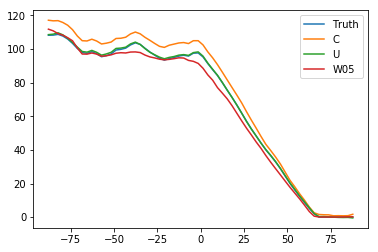

In [263]:
Truth_NetSW = Truth[210,:,:,:]-Truth[211,:,:,:]
C_NetSW = pred_C[210,:,:,:]-pred_C[211,:,:,:]
U_NetSW = pred_U[210,:,:,:]-pred_U[211,:,:,:]
W05_NetSW = pred_W05[210,:,:,:]-pred_W05[211,:,:,:]

plt.plot(coor.lat,np.mean(Truth_NetSW,axis=(0,2)),label='Truth')
plt.plot(coor.lat,np.mean(C_NetSW,axis=(0,2)),label='C')
plt.plot(coor.lat,np.mean(U_NetSW,axis=(0,2)),label='U')
plt.plot(coor.lat,np.mean(W05_NetSW,axis=(0,2)),label='W05')
#plt.plot(ds.lat,np.mean(U_NetSW,axis=(0,2))-np.mean(Truth_NetSW,axis=(0,2)),label='eC')
plt.legend()

## 2.3) Predictions of neural network at a given timestep

### 2.3.1) Lat-lon snapshot

In [102]:
def plot_panels(axes, p, t, var, cmap='bwr', xlabel=True, title='var', labels=None,
                yz=False, coor=coor):
    if yz:
        x, y = lat, lev
        p, t = p, t
    else: 
        x, y = coor.lon, coor.lat
    I1, I2 = [ax.pcolormesh(x, y, a, vmin=lims[var][0], vmax=lims[var][1], cmap=cmap) 
              for ax, a in zip(axes.flat, [p, t])]
    if not yz: [ax.set_aspect('equal') for ax in axes.flat]
    if yz: [ax.invert_yaxis() for ax in axes.flat]
    if xlabel: 
        [ax.set_xlabel('Latitude' if yz else 'Longitude') for ax in axes.flat]
        if not yz: [ax.set_xticks(range(0, 361, 60)) for ax in axes.flat]
    else: [ax.set_xticks([]) for ax in axes.flat]
    axes[0].set_ylabel('Pressure [hPa]' if yz else 'Latitude'); axes[1].set_yticks([])
    if title == 'var':
        pos = [ax.get_position().get_points() for ax in axes.flat]
        pos = pos[0][1][1]
        plt.text(0.45, pos-0.01, name[var], transform=plt.gcf().transFigure,
                 horizontalalignment='center', fontsize=12)
    else:
        axes[0].set_title('CBRAIN Predictions'); axes[1].set_title('SP-CAM Truth')
    if labels is not None:
        [ax.text(0.01, 0.90, l, transform=ax.transAxes, fontsize=12)
         for ax, l in zip(axes, labels)]
    cb = fig.colorbar(I1, ax=axes.ravel().tolist(), shrink=0.75, pad=0.01, extend='both')
    cb.set_label(unit[var])
    cb.formatter.set_powerlimits((-1, 1))
    cb.ax.yaxis.set_offset_position('left') 
    cb.update_ticks()
    return I1, I2

In [71]:
from string import ascii_lowercase
# Labels
labels = []
for i in range(4):
    labels.append([f'{ascii_lowercase[i*2]}) CBRAIN', f'{ascii_lowercase[i*2+1]}) SP-CAM'])
# Plotting ranges
lims = {
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-2e-7, 2e-7],
    'QRL': [-1e-4, 1e-4],
    'QRS': [-1e-4, 1e-4],
}
# Full names
name = {
    'TPHYSTND_NORAD': 'Convective heating rate',
    'PHQ': 'Convective moistening rate',
    'QRL': 'Longwave heating rate',
    'QRS': 'Shortwave heating rate'
}
# Units
unit = {
    'TPHYSTND_NORAD': '[K/s]',
    'PHQ': '[kg/kg/s]',
    'QRL': '[K/s]',
    'QRS': '[K/s]'
}

In [72]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()
# 4) Constants
C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
G = 9.80616; # Reference gravity constant [m.s-2]
L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
P0 = 1e5; # Reference surface pressure [Pa]
        
# 5) Get normalization pressure differences
# norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
dP_NORM = np.divide( \
                     np.multiply(normq[:30], \
                           G), L_V)

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


Reminder:  
The new networks predict:  
[PHQ(0-29), PHCLDLIQ(30-59), PHCLDICE(60-89), TPHYSTND(90-119), QRL(120-149), QRS(150-179), DTVKE(180-209), FSNT(210), FSNS(211), FLNT(212), FLNS(213), PRECT(214), PRECTEND(215), PRECST(216), PRECSTEN(217)] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX]  

Vertical level is fixed at 691.3894303143024 hPa
0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


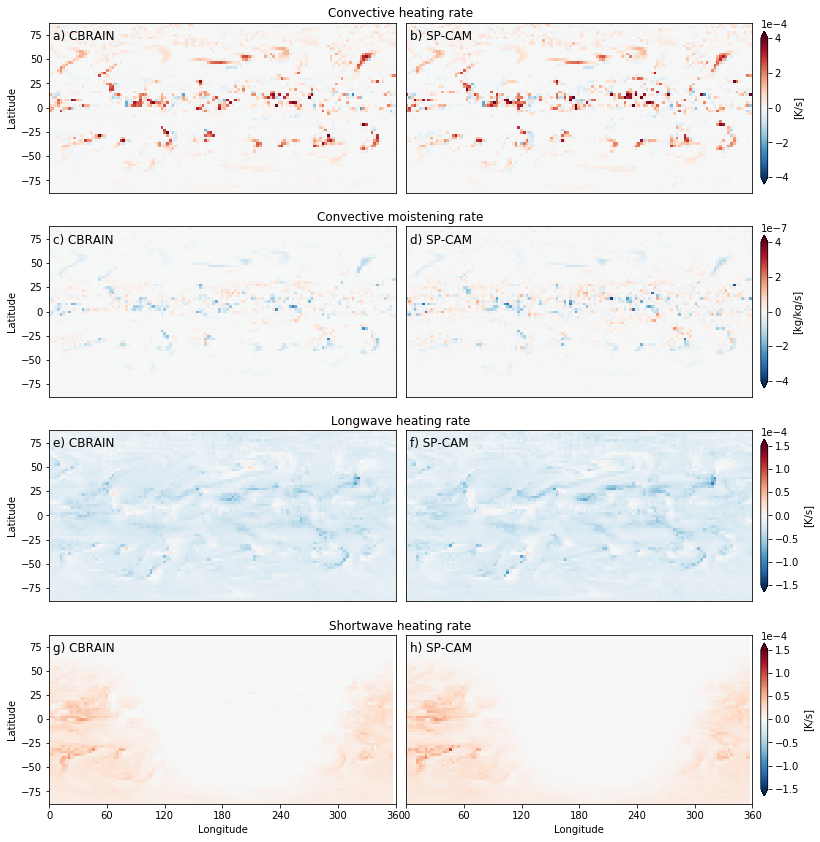

In [84]:
vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS']
PRED = pred_U;
TRU = Truth;
ilev = 20
it = 21
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
print('Vertical level is fixed at',coor.lev.values[ilev],'hPa')
for i, v in enumerate(vars):
    print(i,v)
    if i==0: 
        pred = (PRED[90+ilev,it,:,:]-PRED[120+ilev,it,:,:]-PRED[150+ilev,it,:,:])/(C_P*dP_NORM[ilev]/G);
        tru = (TRU[90+ilev,it,:,:]-TRU[120+ilev,it,:,:]-TRU[150+ilev,it,:,:])/(C_P*dP_NORM[ilev]/G);
    elif i==1: pred = PRED[ilev,it,:,:]/(L_V*dP_NORM[ilev]/G); tru = TRU[ilev,it,:,:]/(L_V*dP_NORM[ilev]/G);
    elif i==2: pred = PRED[120+ilev,it,:,:]/(C_P*dP_NORM[ilev]/G); tru = TRU[120+ilev,it,:,:]/(C_P*dP_NORM[ilev]/G);
    elif i==3: pred = PRED[150+ilev,it,:,:]/(C_P*dP_NORM[ilev]/G); tru = TRU[150+ilev,it,:,:]/(C_P*dP_NORM[ilev]/G);
    plot_panels(axes[i], pred, tru, v, xlabel = True if i == 3 else False, labels=labels[i], cmap='RdBu_r')

In [77]:
# Save figure
figdir = './figures/'
os.makedirs(figdir, exist_ok=True)
fig.savefig(f'{figdir}lat-lon-snap.pdf', bbox_inches='tight', dpi=200)

### 2.3.2) Lat-p snapshot

In [85]:
# Change plotting ranges for clearer figures
lims = {
    'TPHYSTND_NORAD': [-4e-4, 4e-4],
    'PHQ': [-4e-7, 4e-7],
    'QRL': [-1.5e-4, 1.5e-4],
    'QRS': [-1.5e-4, 1.5e-4],
}
lat, lon, lev = coor.lat.values, coor.lon.values, coor.lev.values
# Make sure lat-lon and lev-lat plots have same sizes
# Width / height by calculating the aspect ratio asp
latrange = lat.max()-lat.min(); lonrange = lon.max()-lon.min(); levrange = lev.max()-lev.min()
tmp = lonrange / latrange
asp = (latrange/tmp)/levrange; 
print('Aspect ratio =',asp)

Aspect ratio = 0.0874230126630051


Longitude is fixed at 180.0
0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


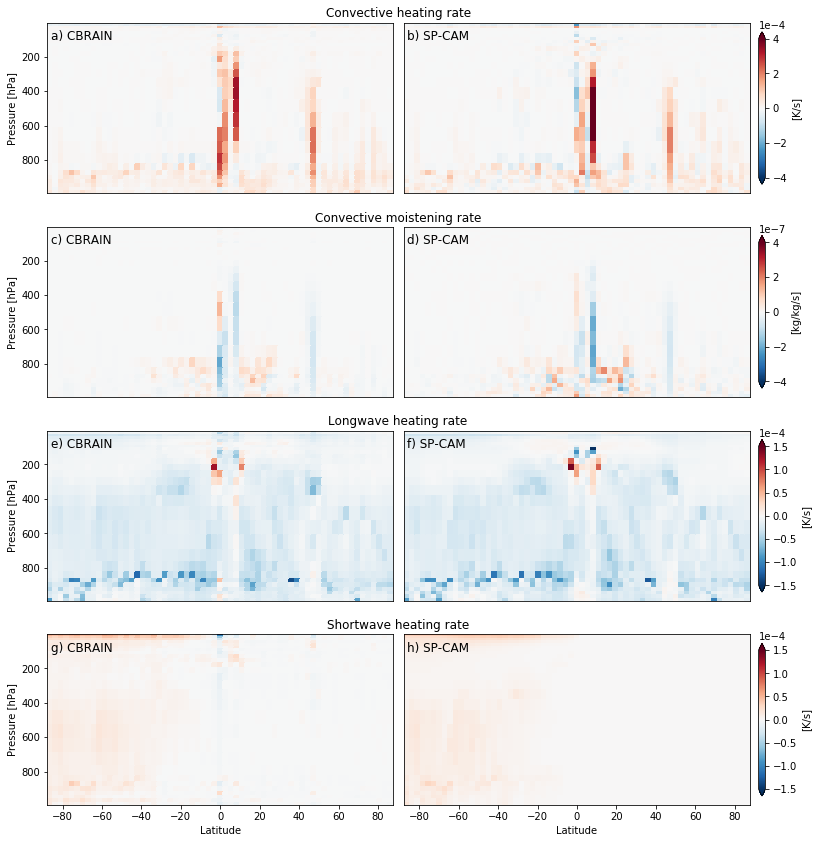

In [106]:
vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS']
PRED = pred_U;
TRU = Truth;
ilon = 64
ilev = np.arange(0,30,1)
it = 35
dP_DIV = dP_NORM.reshape(30,1)

fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
print('Longitude is fixed at',coor.lon.values[ilon])
for i, v in enumerate(vars):
    print(i,v)
    if i==0: 
        pred = (PRED[90+ilev,it,:,ilon]-PRED[120+ilev,it,:,ilon]-PRED[150+ilev,it,:,ilon])/(C_P*dP_DIV/G);
        tru = (TRU[90+ilev,it,:,ilon]-TRU[120+ilev,it,:,ilon]-TRU[150+ilev,it,:,ilon])/(C_P*dP_DIV/G);
    elif i==1: pred = PRED[ilev,it,:,ilon]/(L_V*dP_DIV/G); tru = TRU[ilev,it,:,ilon]/(L_V*dP_DIV/G);
    elif i==2: pred = PRED[120+ilev,it,:,ilon]/(C_P*dP_DIV/G); tru = TRU[120+ilev,it,:,ilon]/(C_P*dP_DIV/G);
    elif i==3: pred = PRED[150+ilev,it,:,ilon]/(C_P*dP_DIV/G); tru = TRU[150+ilev,it,:,ilon]/(C_P*dP_DIV/G);
    plot_panels(axes[i], pred, tru, v, xlabel = True if i == 3 else False, labels=labels[i], cmap='RdBu_r', yz=True)
    [ax.set_aspect(asp) for ax in axes.flat];

In [ ]:
# Save figure
fig.savefig(f'{figdir}height-lat-snap.pdf', bbox_inches='tight', dpi=200)

# 3) Bias figures
## 3.1) R2 statistics

tgb - 3/19/2019 - Following:    
https://github.com/raspstephan/CBRAIN-CAM/blob/master/notebooks/presentation/grl_paper.ipynb

lat-lev, averaged over lon: MSE, TVAR, PVAR, R2, bias

lev, averaged over lat, lon: R2

For each output variable [TPHYSTND_NORAD, PHQ, QRL, QRS] the $R^2$ is computed for each level $z$ and then averaged:

$$ R^2_z = 1 - (SSE_z / TVAR_z) $$

where SSE, the sum of squared errors is computed from the predicted values $y$ and the corresponding true values $\hat{y}$:

$$ SSE_z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (y_{t, x, y} - \hat{y}_{t, x, y})^2$$

and the TVAR, the true variance is:

$$ TVAR_Z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (\hat{y}_{t, x, y} - \bar{\hat{y}})^2 $$

with $\bar{\hat{y}}$ being the true mean over $t, x, y$.

## 3.2) Lat-lon-time averaged statistics

In [284]:
# Calculate lat/lon-averaged statistics
Nvar = 4;
maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC
sse = np.zeros(shape=(Nvar,Nlev))
tvar = np.zeros(shape=(Nvar,Nlev))
mask = np.zeros(shape=(Nvar,Nlev))
PRED = pred_C;
TRU = Truth;
dP_DIV = dP_NORM.reshape(30,1,1,1)
ilev = np.arange(0,30,1)
for i, v in enumerate(vars):
    print(i,v)
    if i==0: 
        pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
        tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
    elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
    elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
    elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);

    sse[i,:] = np.mean(abs(pred-tru)**2,axis=(1,2,3));
    tvar[i,:] = np.mean(abs(tru-np.mean(tru,axis=(1,2,3)).reshape(tru.shape[0],1,1,1))**2,axis=(1,2,3));
    mask[i,:] = tvar[i,:]<maskC*tvar[i,:].mean(axis=(0))
r2 = 1-sse/tvar;
mask = mask.astype(int); # Convert mask to integer array

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [285]:
def despine(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

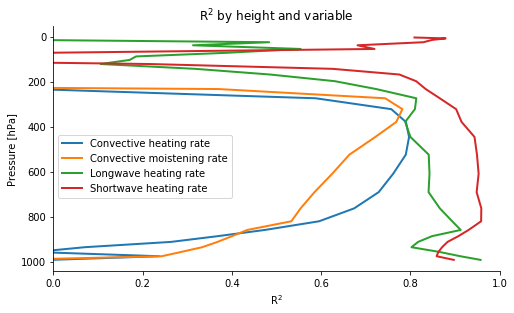

In [286]:
fig, ax = plt.subplots(figsize=(8,4.5))
for i, v in enumerate(vars):
    ax.plot(r2[i,:], lev, label=name[v], linewidth=2)
ax.invert_yaxis()
ax.set_ylabel('Pressure [hPa]'); ax.set_xlabel(r'R$^2$')
ax.set_xlim(0, 1)
ax.set_title(r'R$^2$ by height and variable')
despine(ax)
ax.legend(loc=(0.01,0.3));

## 3.3) Lon-time averaged statistics

In [360]:
# Calculate lat/lon-averaged statistics
Nvar = 4;
maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC
sse = np.zeros(shape=(Nvar,Nlev,Nlat))
tvar = np.zeros(shape=(Nvar,Nlev,Nlat))
mask = np.zeros(shape=(Nvar,Nlev,Nlat))
PRED = pred_U;
TRU = Truth;
dP_DIV = dP_NORM.reshape(30,1,1,1)
ilev = np.arange(0,30,1)
for i, v in enumerate(vars):
    print(i,v)
    if i==0: 
        pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
        tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
    elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
    elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
    elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);

    sse[i,:,:] = np.mean(abs(pred-tru)**2,axis=(1,3));
    tvar[i,:,:] = np.mean(abs(tru-np.mean(tru,axis=(1,3)).reshape(tru.shape[0],1,tru.shape[2],1))**2,axis=(1,3));
    mask[i,:,:] = tvar[i,:,:]<maskC*np.mean(tvar[i,:,:],axis=1).reshape(1,tvar.shape[1],1)
r2 = 1-sse/tvar;
mask = mask.astype(int); # Convert mask to integer array

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [361]:
from matplotlib import patches, patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='white'), patheffects.Normal()])

In [364]:
def plot_4stats(ivar, stat, title='', vmult=1, only_pos=False, func=None, mylims=None, rows=2,
                letter_offset=0, masks=None, extend='both', **kwargs):
    fig, axes = plt.subplots(rows, 2, figsize=(15, 3.5 * rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.0, hspace=0.)
    for i, (ax, v) in enumerate(zip(axes.flat, vars)):
        print('i=',i,'(ax,v)=',(ax,v),'func=',func,'stat=',stat)
        if func:
            a = func(d, v)
        else:
            if stat=='r2': a = r2[i,:,:];
            elif stat=='tvar': a = tvar[i,:,:] 
        if mylims is None: 
            vmin = 0 if only_pos else lims[v][0]*vmult
            vmax = lims[v][1]*vmult
        else:
            vmin = mylims[0]; vmax = mylims[1]

        if masks is not None: a[masks[i,:,:]==1] = np.nan

        I = ax.pcolormesh(lat, lev, a, vmin=vmin, vmax=vmax, **kwargs)
        txt = ax.text(0.01, 0.90, f'{ascii_lowercase[i+letter_offset]}) {name[v]}', 
                      transform=ax.transAxes, fontsize=12)
        draw_outline(txt, 2)
        cb = fig.colorbar(I, ax=ax, orientation='vertical', shrink=0.8, pad=0.02, 
                          extend=extend)
        cb.set_label(unit[v])
        cb.formatter.set_powerlimits((-1, 1))
        cb.ax.yaxis.set_offset_position('left') 
        cb.update_ticks()
        
    [ax.set_ylabel('Pressure [hPa]') for ax in axes[:,0].flat]
    [ax.set_yticks([]) for ax in axes[:,1].flat]
    [ax.invert_yaxis() for ax in axes.flat]
    if rows > 1: [ax.set_xticks([]) for ax in axes[0].flat]
    [ax.set_xlabel('Latitude') for ax in axes[-1].flat]
    [ax.set_aspect(asp) for ax in axes.flat];
    fig.suptitle(title, fontsize=14, x=0.47,y=0.93)
    return fig

i= 0 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15047df22d30>, 'TPHYSTND_NORAD') func= None stat= r2
i= 1 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15049102aa20>, 'PHQ') func= None stat= r2
i= 2 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15047dc02c50>, 'QRL') func= None stat= r2
i= 3 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15047c520208>, 'QRS') func= None stat= r2


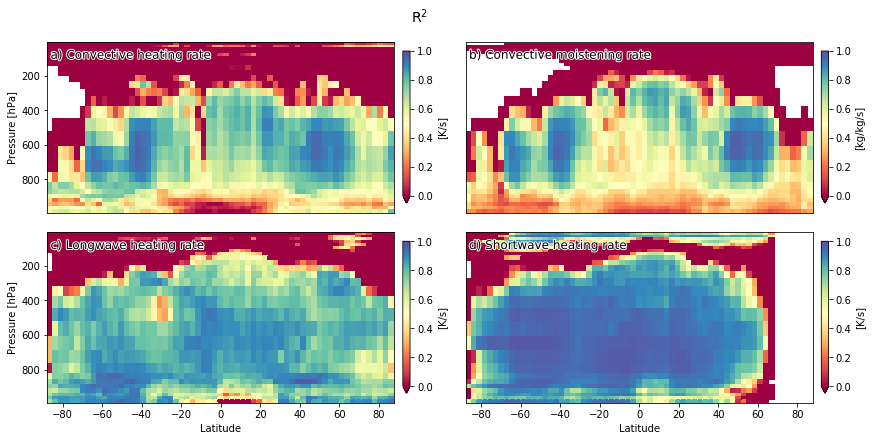

In [367]:
ivar = 0;
f = plot_4stats(ivar, 'r2', r'R$^2$', cmap='Spectral', mylims=[0, 1], only_pos=True,
                masks=mask, extend='min')

In [314]:
f = plot_4stats(d, '', 'tvar', vmult=0.5, cmap='Spectral_r', only_pos=True,
                func=None, v: np.sqrt(tvar.mean(1)),
                masks=mask, rows=1, letter_offset=2)

SyntaxError: invalid syntax (<ipython-input-314-3eaf6d188c48>, line 2)